# Demand Forecasting Using ARIMA/SARIMAX

This notebook provides a template for creating demand forecasting models using traditional autoregressive models (ARIMA family).

### Use Case
We assume a single entity (SKU, product, etc.) that is modeled separately from other entities. For this entity, we have one metric (revenue, profit, sales volume, etc.) which we want to predict. We have historical data for this metric which can be used to fit the model. Optionally, we might have covariates (exogenous variables) which are assumed to be known for both past and future time intervals.   

### Prototype: Approach and Data
We implement the standard process for fitting ARIMA and SARIMAX models including initial time series validation, model parameters selection, and fitting and forecasting. The notebook uses the retail sales datasets that is available in the `tensor-house-data` repository.

### Usage and Productization
The data used for prototyping can be easily replaced by the actual data. Productization will also require to engineer the covariates.

In [35]:
#
# Imports and settings
#
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def distplot(data, distribution, **kwargs):
    xx = np.linspace(data.min(), data.max(), 100)
    sns.histplot(data, stat='density', kde=False, **kwargs)
    sns.lineplot(x=xx, y=distribution.pdf(xx, *distribution.fit(data)), **kwargs)

---
# Step 1: Load and Filter Data

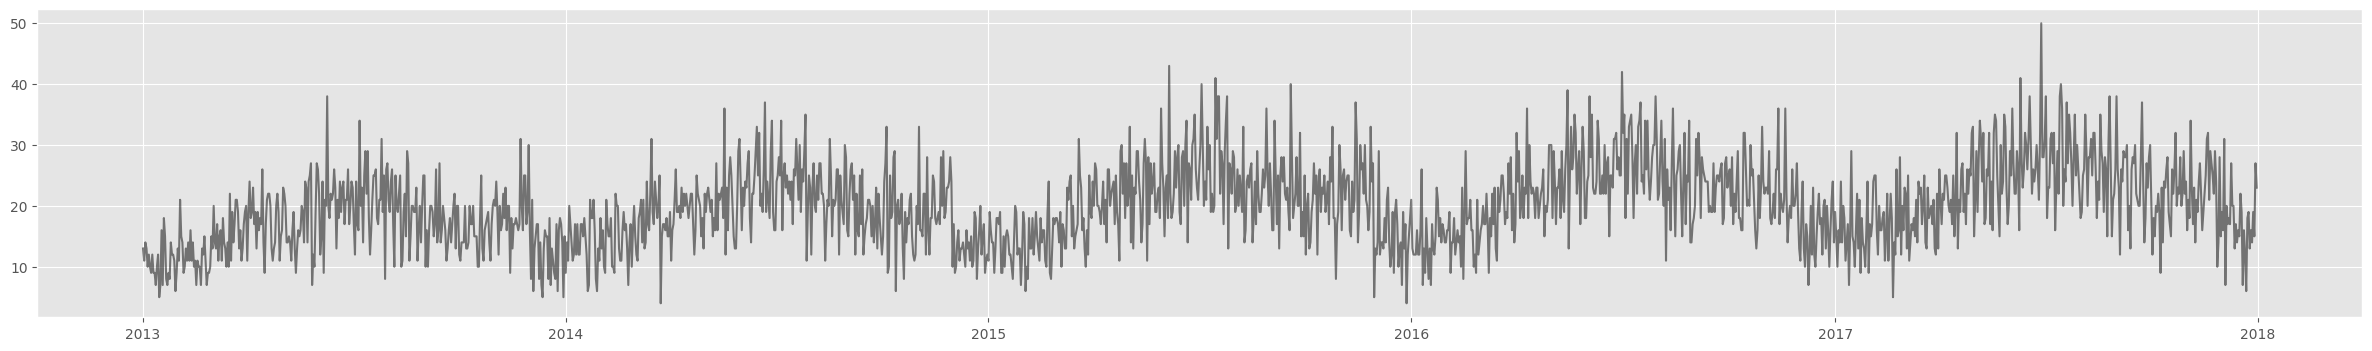

In [36]:
#
# This dataset is a daily series of sales quantities for 
# several stores and items (products) for a time range of 5 years 
#
data_path = '../../tensor-house-data/time-series'
data = pd.read_csv(f'{data_path}/store-item-sales.csv.zip', compression='zip', parse_dates=['date'], index_col='date')

# Take one series for store #1 and item #1
data = data.query('store == 1 & item == 1')

ts = data['sales']

plt.figure(figsize=(30,4))
plt.plot(ts, color='black', alpha=0.5)
plt.show()

---
# Step 2: Analyze Data Properties and Feasibility

We first check whether the data is stationary, that is:
* The mean is constant
* The variance is constant
* Covariance doesn't depend on time (no trends or seasonality, but cycles can be present)

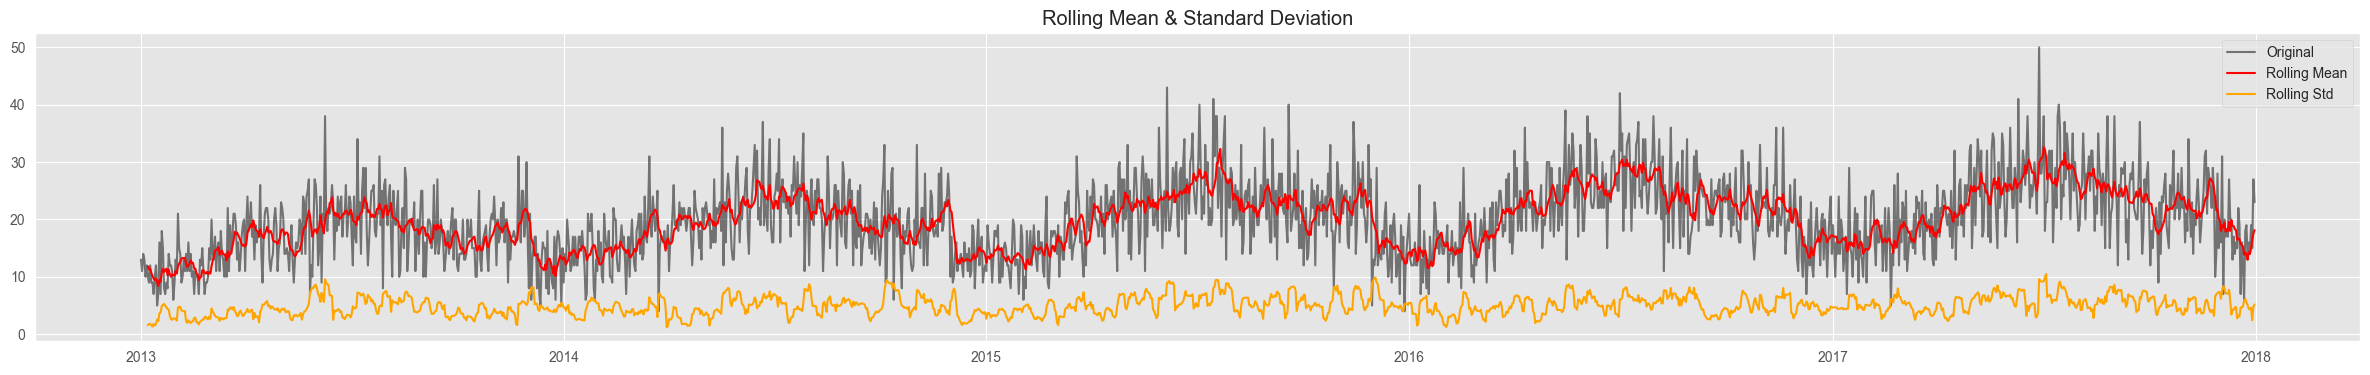

Dickey-Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, mean_window = 7, var_window = 7):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window = mean_window).mean()
    rolstd = timeseries.rolling(window = var_window).std()

    # Plot rolling statistics:
    plt.figure(figsize=(30,4))
    orig = plt.plot(timeseries, color='black', label='Original', alpha=0.5)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

* There is an upward trend, but variance stays relatively constant. 
* There are clear seasonal peaks in the middle of every year.

The next step is to differentiate the time series and assess the stationarity characteristics again.

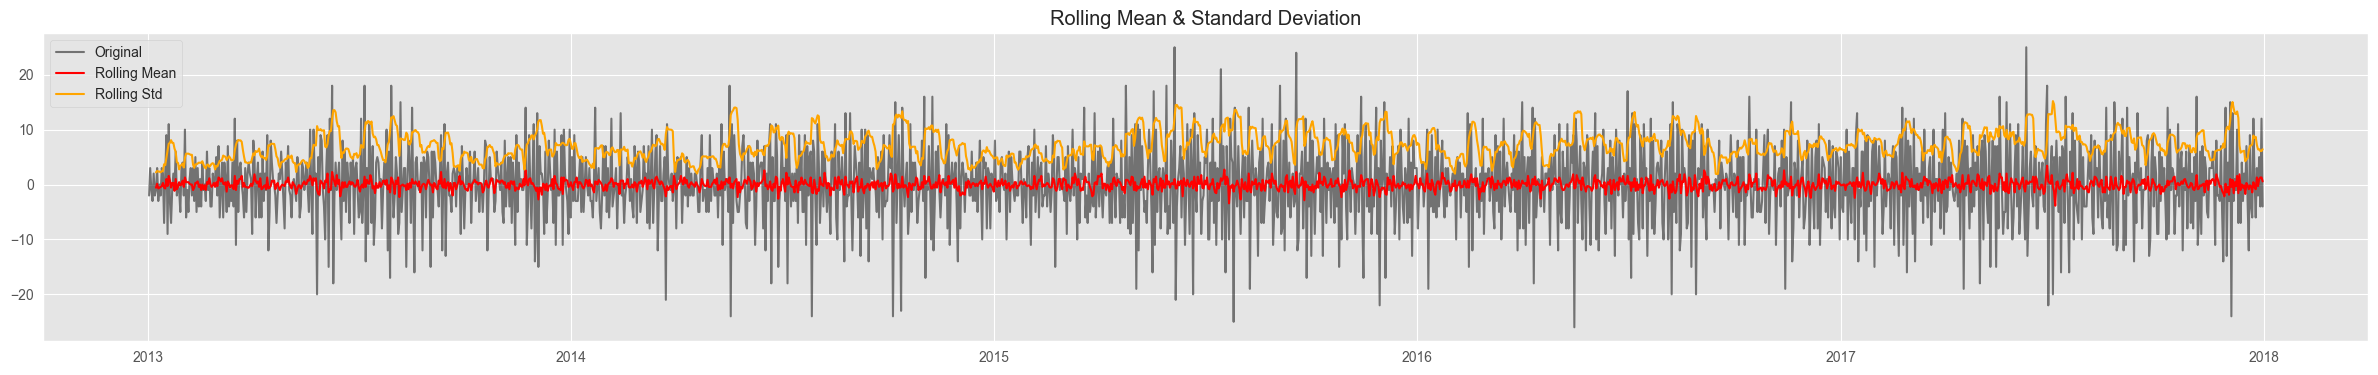

Dickey-Fuller Test:
Test Statistic                -1.267679e+01
p-value                        1.210928e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


In [7]:
ts_diff = ts - ts.shift(1)
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

Now the series looks stationary. The mean is constant, test statistic is below 1% and p-value is low. 

---
## Step 3: Parameter Estimation

The next step is to compute autocorrelation (ACF) and partial autocorrelation (PACF) functions. ACF/PACF properties will be used to pick proper ARIMA and SARIMA parameters p, d, q. Refer to Part 1 for a theoretical background. 

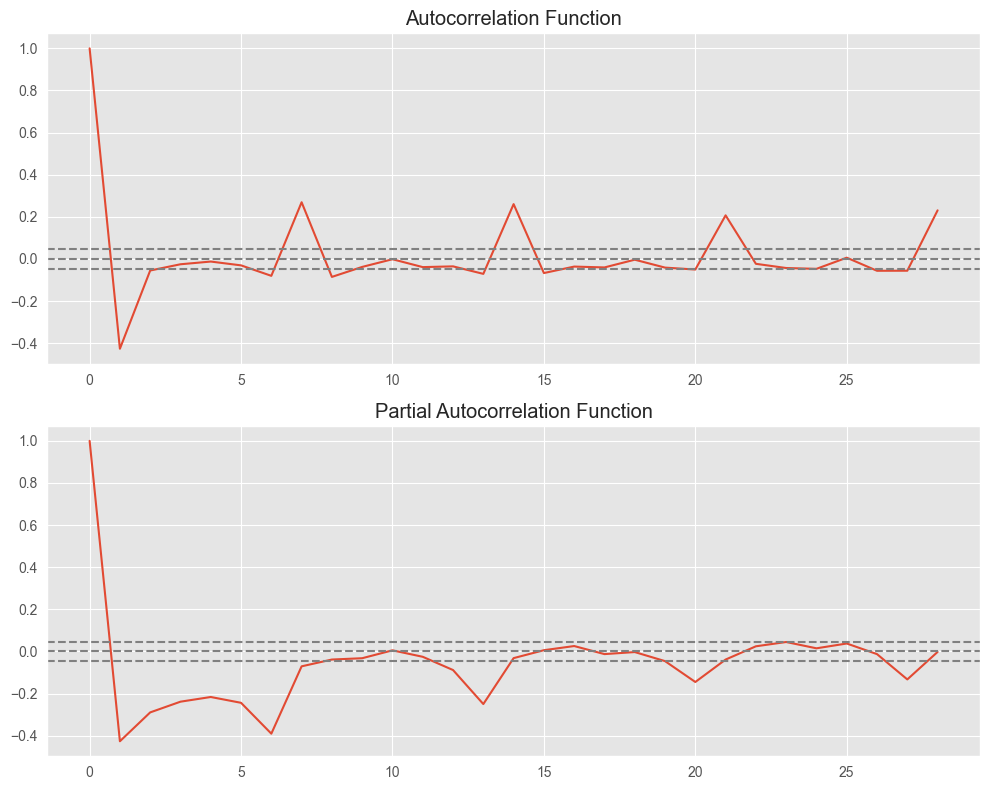

In [8]:
from statsmodels.tsa.stattools import acf, pacf

acf = acf(ts_diff, nlags=28)
pacf = pacf(ts_diff, nlags=28, method='ols')

fig, ax = plt.subplots(2, 1, sharey=True, figsize=(10, 8))

for i, (ac, ac_name) in enumerate([(acf, 'Autocorrelation Function'), (pacf, 'Partial Autocorrelation Function')]):
    ax[i].plot(ac)
    ci_boundary = 1.96/np.sqrt(len(ts_diff))
    for ci_line in [0, -ci_boundary, ci_boundary]:
        ax[i].axhline(y=ci_line, linestyle='--', color='gray')
    ax[i].title.set_text(ac_name)
    
plt.tight_layout()

We make the following choices for ARIMA model parameters:
* We choose the difference parameter d to be 1 based on the previous analysis that shown that the differentiated series is stationary.
* We set parameter p for AR(p) process to 7 because PACF cuts off at this point, except seasonal spikes.
* We set parameter q for MA(q) process to 2, based on the ACF. This excludes seasonal spikes as well.

---
## Step 4: Fitting ARIMA

/Users/ikatsov/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'MSE: 26.35')

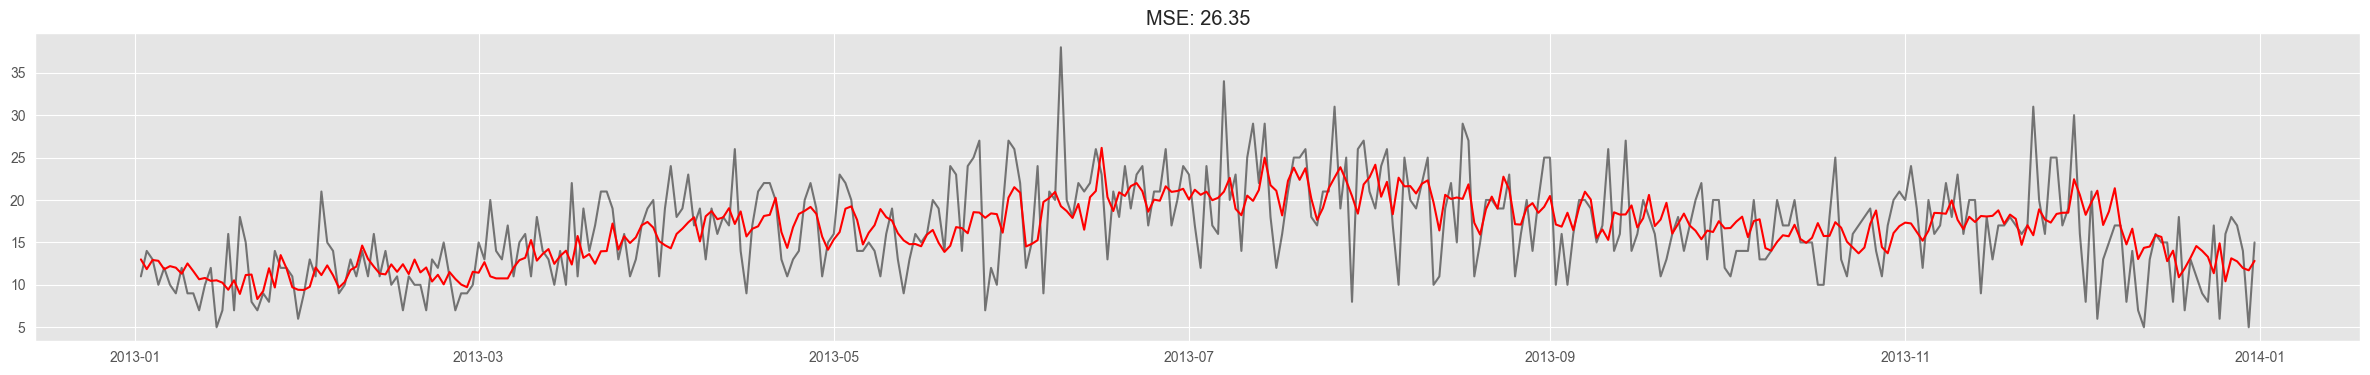

In [28]:
arima_model = ARIMA(endog=ts, order=(7, 1, 2), freq='D').fit()
fitted_values_arima = arima_model.predict(typ='levels')

plt.figure(figsize=(30,4))
plt.plot(ts['2013'][1:], color='black', alpha=0.5)
plt.plot(fitted_values_arima['2013'][1:], color='red')
mse = mean_squared_error(fitted_values_arima, ts)
plt.title(f'MSE: {mse:.2f}')

---
## Step 5: Fitting SARIMAX

/Users/ikatsov/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ikatsov/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'MSE: 23.60')

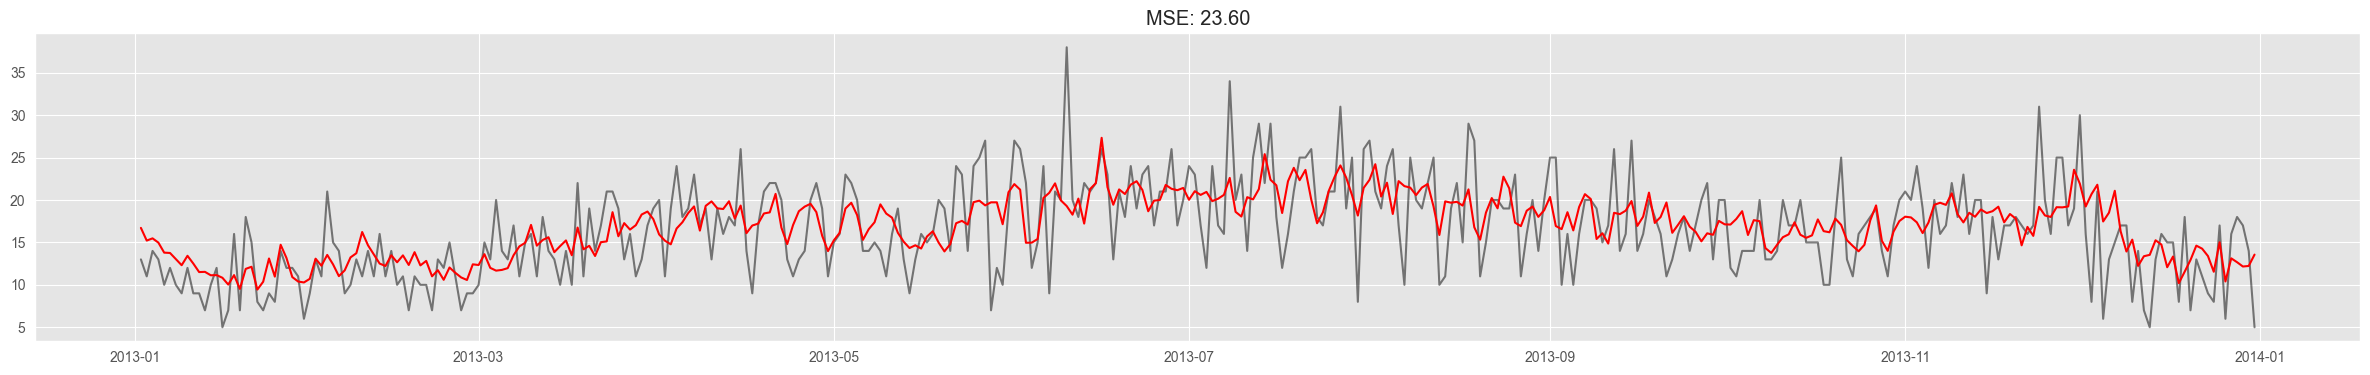

In [30]:
sarimax_model = sarimax.SARIMAX(endog=ts, trend='c', freq='D', order=(7, 0, 2), seasonal_order=(1, 0, 1, 30)).fit(disp=False)
fitted_values_sarimax = sarimax_model.predict(typ='levels')

plt.figure(figsize=(30, 4))
plt.plot(ts['2013'].shift(), color='black', alpha=0.5)
plt.plot(fitted_values_sarimax['2013'][1:], color='red')
mse = mean_squared_error(fitted_values_sarimax[1:], ts.shift()[1:])
plt.title(f'MSE: {mse:.2f}')

---
## Step 6: Checking the Residuals

The next step is to check the distribution and autororrelation of the residuals.

NormaltestResult(statistic=22.979480175680685, pvalue=1.0234562473446272e-05)


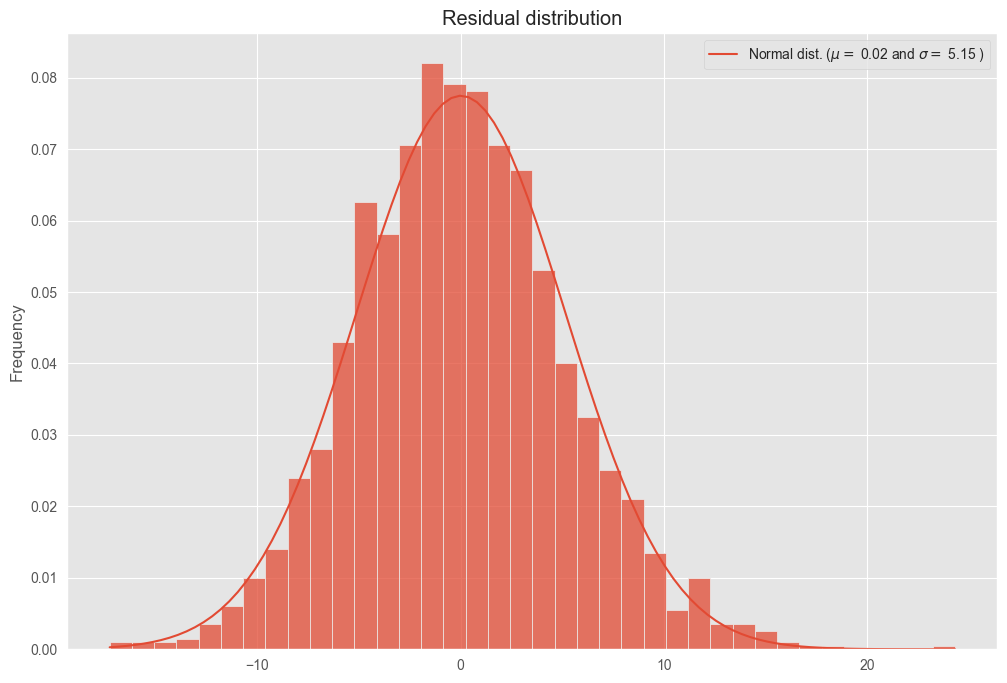

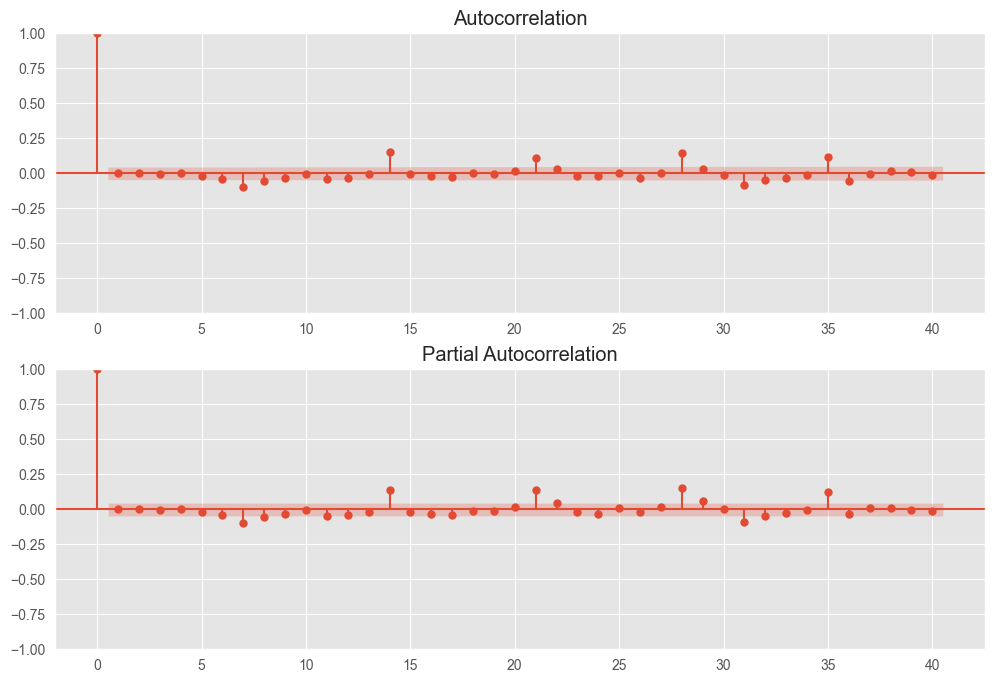

In [32]:
def plot_residuals(residuals): 
    print(normaltest(residuals))

    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)

    # Plot the distribution
    distplot(residuals, distribution = stats.norm, ax = ax0)
    (mu, sigma) = stats.norm.fit(residuals)  
    plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')

    # ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)
    
plot_residuals(sarimax_model.resid)

---
## Step 7: In/Out of Sample Forecasting with SARIMAX

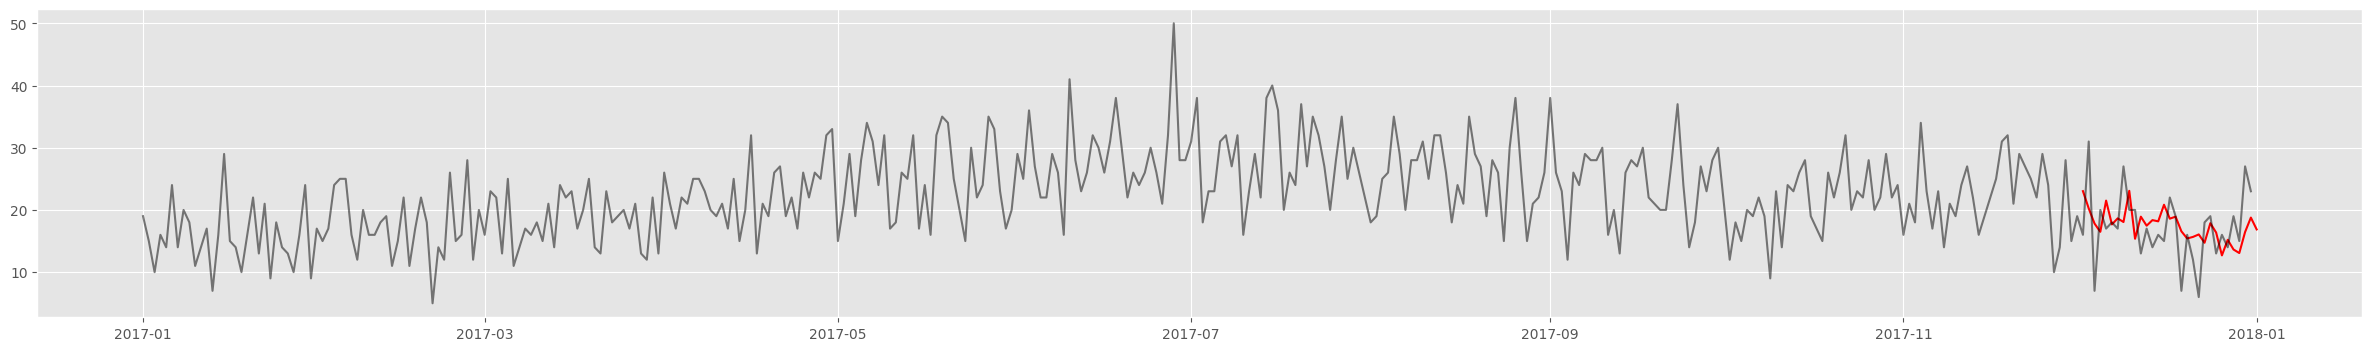

In [37]:
#
# In-sample forecasting
#
n = len(sarimax_model.fittedvalues) 
predicted = sarimax_model.predict(n - 30, n)

plt.figure(figsize=(30, 4))
plt.plot(predicted, color='red')
plt.plot(ts['2017'], color='black', alpha=0.5)

<Axes: xlabel='date'>

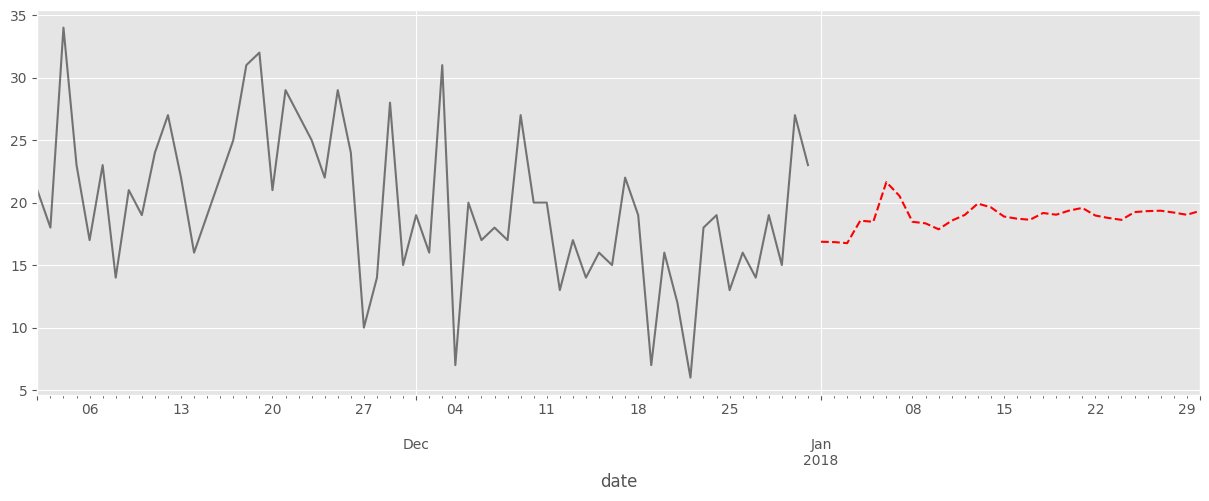

In [38]:
#
# Out-of-sample forecasting
#
fcast = sarimax_model.get_forecast(30).summary_frame()
fig, ax = plt.subplots(figsize=(15, 5))
ts[-60:].plot(ax = ax, color='black', alpha=0.5)
fcast['mean'].plot(ax = ax, style='r--')

---
## Step 8: Improving the Model Using Exogenous Features

The next step is to improve the results using exogenous features like holidays, weekends, and pre/post holiday day indicators.

In [79]:
def make_data_exog(start_date, end_date):
    # load holidays
    holiday = pd.read_csv(f'{data_path}/usholidays-1966-2020.csv', header=0, names = ['id','date', 'holiday'])
    holiday['date'] = pd.to_datetime(holiday['date'], yearfirst = True, format = '%Y-%m-%d')

    # remove unused holidays
    holiday = holiday[holiday['date'] >= start_date]
    holiday = holiday[holiday['date'] < end_date]

    train_df = pd.DataFrame({'date': pd.date_range(start_date, end_date, freq='D')})
    train_df['year'] = train_df['date'].dt.year - 2012
    train_df['month'] = train_df['date'].dt.month
    train_df['day'] = train_df['date'].dt.dayofyear
    train_df['weekday'] = train_df['date'].dt.weekday
    train_df = train_df.merge(holiday, how='left', on='date')
    train_df['holiday_bool'] = pd.notnull(train_df['holiday']).astype(int)
    train_df = pd.get_dummies(train_df, columns = ['holiday', 'month', 'weekday'] , prefix = ['holiday', 'month', 'weekday'], dtype=int)
    train_df = train_df.set_index('date')
    
    return train_df.drop(columns=['id'], inplace=False, axis=1)

y = data.sales
x = make_data_exog(start_date='2013-01-01', end_date='2017-12-31')

x.tail()

,year,day,holiday_bool,"holiday_Birthday of Martin Luther King, Jr.",holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Memorial Day,holiday_New Year's Day,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,5,361,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2017-12-28,5,362,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2017-12-29,5,363,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2017-12-30,5,364,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2017-12-31,5,365,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
#
# Model fitting
# 
sarimax_exog_model = sm.tsa.statespace.SARIMAX(endog = y,
                                        exog = x,  
                                        trend='n', 
                                        order=(7, 0, 2), 
                                        seasonal_order=(1, 0, 1, 30)).fit()

Text(0.5, 1.0, 'MSE: SARIMAX Endogenous 21.08, SARIMAX Exogenous: 28.69')

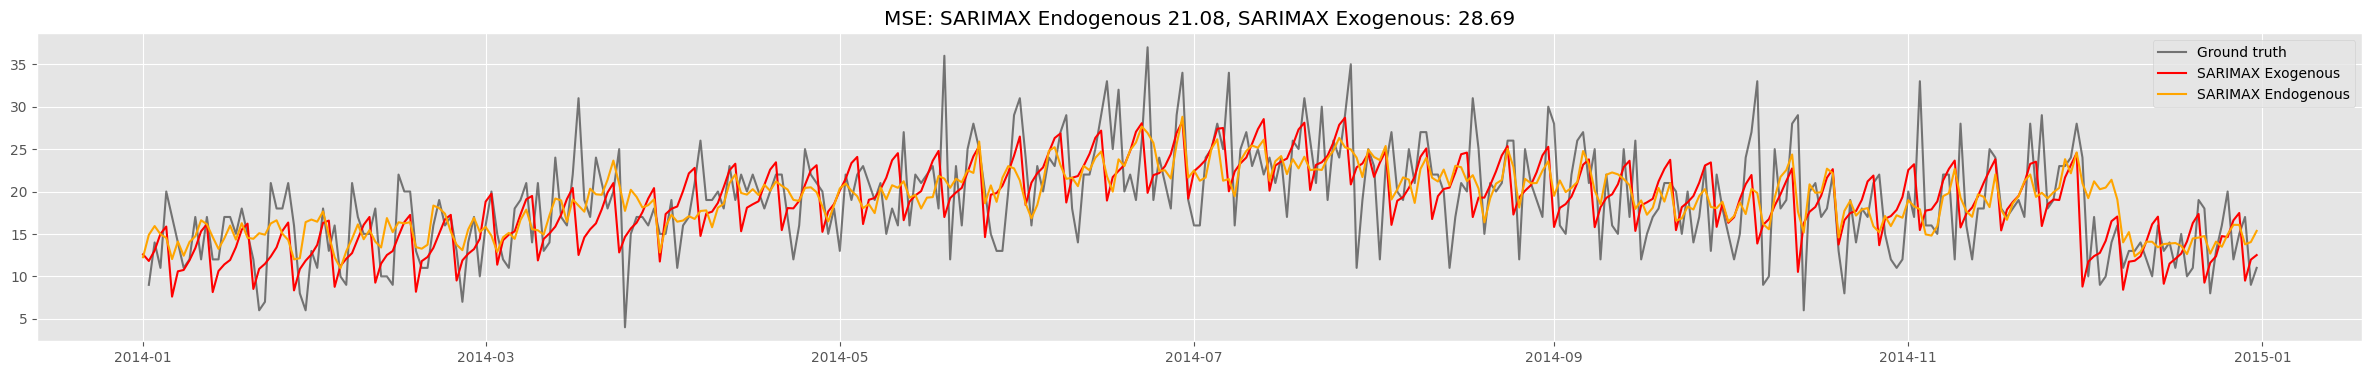

In [81]:
#
# In-sample forecast
#
fitted_values_sarimax_exog = sarimax_exog_model.predict(typ='levels')

plot_year = '2014'
plt.figure(figsize=(30, 4))
plt.plot(ts[plot_year].shift(), color='black', alpha=0.5, label='Ground truth')
plt.plot(fitted_values_sarimax_exog[plot_year], color='red', label='SARIMAX Exogenous')
plt.plot(fitted_values_sarimax[plot_year], color='orange', label='SARIMAX Endogenous')
plt.legend()
mse_endog = mean_squared_error(fitted_values_sarimax[plot_year][1:], ts[plot_year].shift()[1:])
mse_exog = mean_squared_error(fitted_values_sarimax_exog[plot_year][1:], ts[plot_year].shift()[1:])
plt.title(f'MSE: SARIMAX Endogenous {mse_endog:.2f}, SARIMAX Exogenous: {mse_exog:.2f}')

Note that we have a much more regular and meaningful structure aligned with weekly cycles for the model with exogenous features.

<Axes: xlabel='date'>

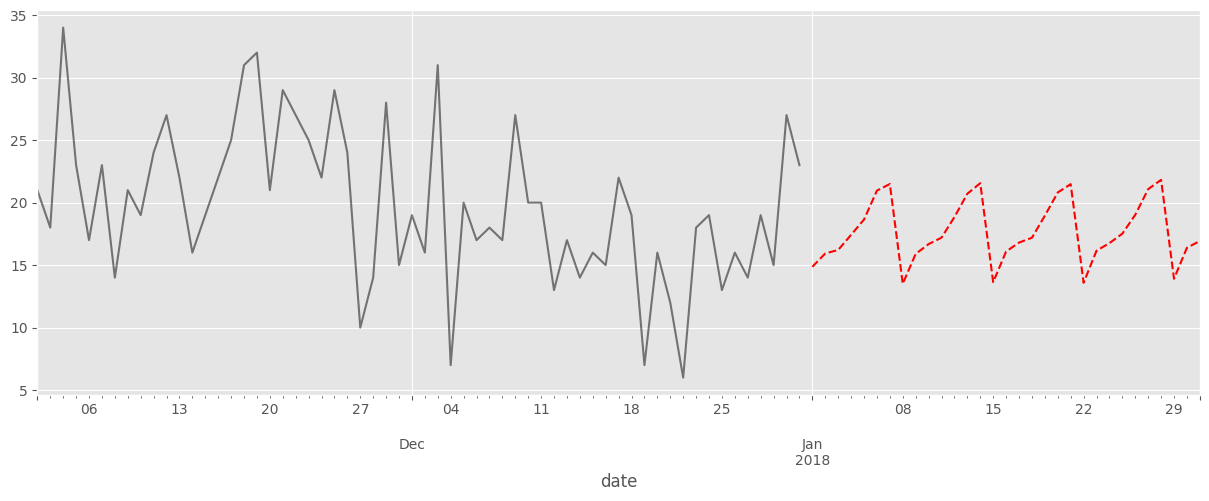

In [85]:
#
# Out-of-sample forecast
#
n_steps_ahead = 31
x_out_of_sample = make_data_exog(start_date='2018-01-01', end_date='2019-01-31')[:n_steps_ahead]
out_of_sample_sarimax_exog = sarimax_exog_model.get_forecast(n_steps_ahead, exog=x_out_of_sample).summary_frame()

_, ax = plt.subplots(figsize=(15, 5))
y[-60:].plot(ax = ax, color='black', alpha=0.5)
out_of_sample_sarimax_exog['mean'].plot(ax = ax, style='r--')

---
## Step 9: Checking the Residual

Finally, we check the residuals for SARIMAX model with exogenous features.

NormaltestResult(statistic=23.431013195134355, pvalue=8.166202253907315e-06)


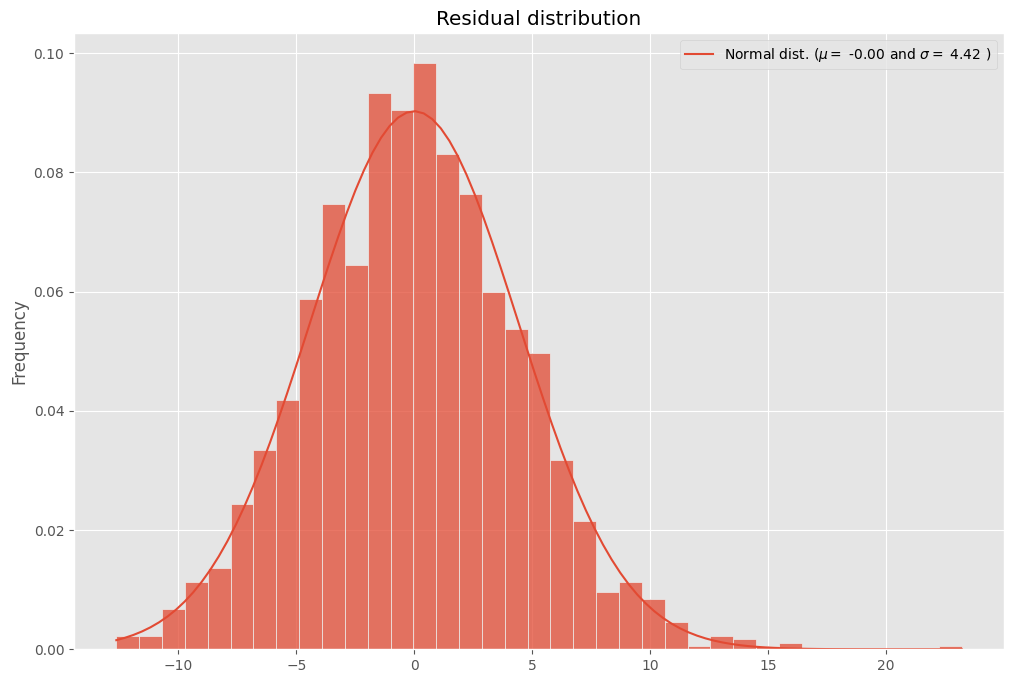

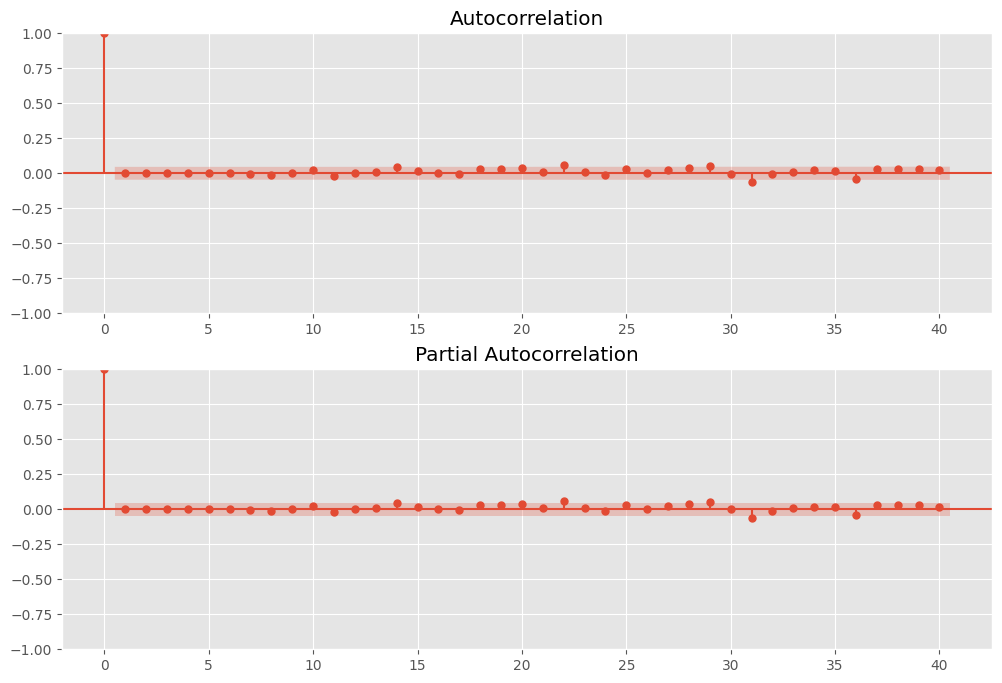

In [57]:
resid = plot_residuals(sarimax_exog_model.resid)